<a href="https://colab.research.google.com/github/gayakwadmilind/ML/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install shap
!pip install LIME
!pip install interpret-core



from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import interpret.glassbox
import xgboost
import shap
import lime
import lime.lime_tabular
import sklearn
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# As a first stage, you get the data, then convert specific features already in string format using a label encoder.
# You divide the data into 80 percent for training and 20 percent for testing following the transformation.
# To keep the classes balanced, maintain the percentage of churn and no-churn cases while generating the train/test split.
# The model is then trained, and the learned model is applied to the test data.

# %%
data = pd.read_csv('/content/drive/MyDrive/telecom_train.csv')
data.head()
data.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   region    700 non-null    int64  
 1   tenure    700 non-null    int64  
 2   age       700 non-null    int64  
 3   marital   700 non-null    int64  
 4   address   700 non-null    int64  
 5   income    700 non-null    int64  
 6   ed        700 non-null    int64  
 7   emply     700 non-null    int64  
 8   retire    700 non-null    int64  
 9   gender    700 non-null    int64  
 10  reside    700 non-null    int64  
 11  tollfree  700 non-null    int64  
 12  equip     700 non-null    int64  
 13  callcard  700 non-null    int64  
 14  wireless  700 non-null    int64  
 15  logmon    700 non-null    float64
 16  tollmon   700 non-null    float64
 17  equipmon  700 non-nu

In [ ]:
le = LabelEncoder() ## perform label encoding
data['area_code_tr'] = le.fit_transform(data['area_code'])
del data['area_code'] ## delete area_code
data['churn_dum'] = pd.get_dummies(data.
churn,prefix='churn',drop_first=True)
del data['international_plan'] ## delete international_plan
del data['voice_mail_plan'] ## delete voice_mail_plan
del data['churn'] ## delete churn
data.info()
data.columns

KeyError: 'area_code'

In [ ]:
X = data[['tollfree', 'wireless', 'callcard', 'equip']]
Y = data['churn']

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.20,stratify=Y)
l_model = LogisticRegression(max_iter=10000)
l_model.fit(xtrain,ytrain)
print("training accuracy:", l_model.score(xtrain,ytrain)) #training accuracy
print("test accuracy:",l_model.score(xtest,ytest)) # test accuracy

training accuracy: 0.7714285714285715
test accuracy: 0.8357142857142857


In [ ]:
print(np.round(l_model.coef_,2))## Coeffiscient
print(l_model.intercept_) ## intercept

[[ 0.24  0.63 -1.28  1.12]]
[-1.06430338]


In [ ]:
def m_churn_proba(x):
   return l_model.predict_proba(x)[:,1]
# Provide Log Odds as Output
def model_churn_log_odds(x):
   p = l_model.predict_log_proba(x)
   return p[:,1] - p[:,0]

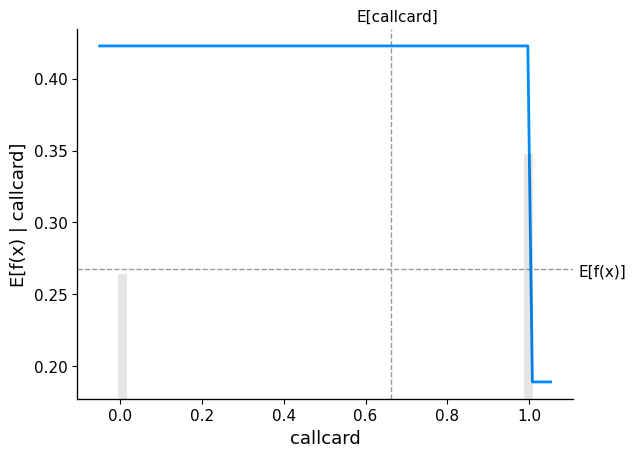

In [ ]:
sample_ind = 25
fig,ax = shap.partial_dependence_plot(
"callcard", m_churn_proba, X, model_expected_value=True,
feature_expected_value=True, show=False, ice=False)

In [ ]:
background_c = shap.maskers.Independent(X, max_samples=1000) ## Concealed features may be hidden by using this function.
explainer = shap.Explainer(l_model, background_c,
feature_names=list(X.columns))
shap_values_c = explainer(X)
shap_values = pd.DataFrame(shap_values_c.values)
shap_values.columns = list(X.columns)
shap_values

,tollfree,wireless,callcard,equip
0,-0.108568,-0.176446,-0.432207,-0.442755
1,0.128925,0.456949,-0.432207,-0.442755
2,0.128925,-0.176446,-0.432207,-0.442755
3,-0.108568,-0.176446,0.849762,-0.442755
4,-0.108568,-0.176446,0.849762,-0.442755
...,...,...,...,...
695,0.128925,-0.176446,-0.432207,-0.442755
696,-0.108568,0.456949,-0.432207,0.676120
697,-0.108568,-0.176446,-0.432207,-0.442755
698,0.128925,0.456949,-0.432207,-0.442755


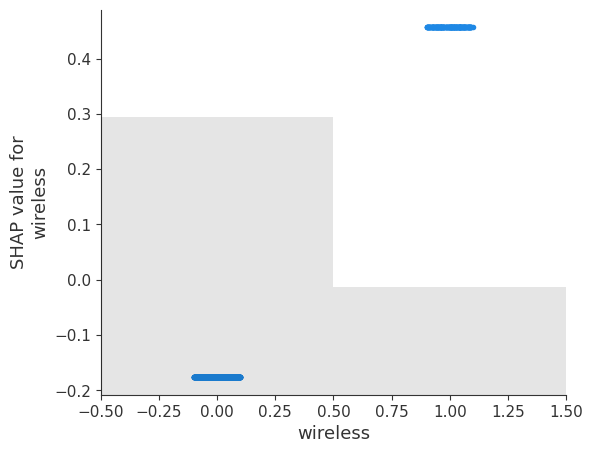

In [ ]:
shap.plots.scatter(shap_values_c[:,'wireless'])

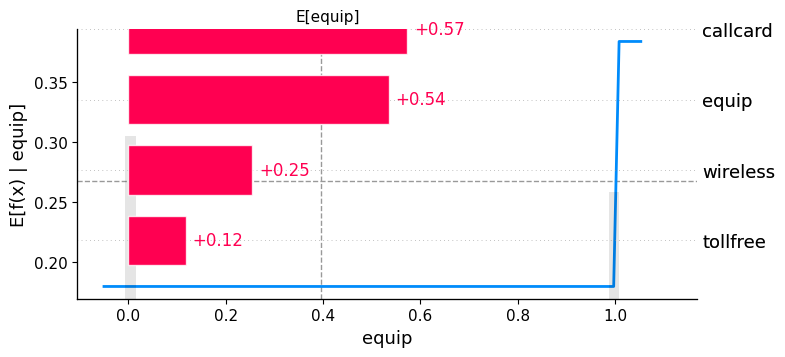

In [ ]:
sample_ind = 25
fig,ax = shap.partial_dependence_plot(
"equip", m_churn_proba, X, model_expected_value=True,
feature_expected_value=True, show=False, ice=False
)
shap_values_c.feature_names
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(l_model, background_c,
feature_n=list(X.columns))
shap_values_churn_l = explainer_log_odds(X)
shap_values_churn_l
shap.plots.bar(shap_values_churn_l)

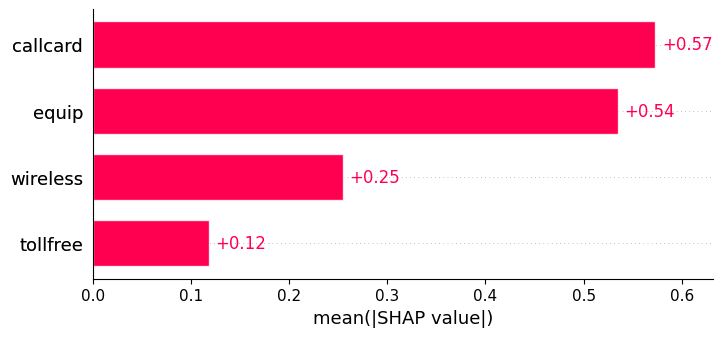

In [ ]:
shap.plots.bar(shap_values_churn_l)

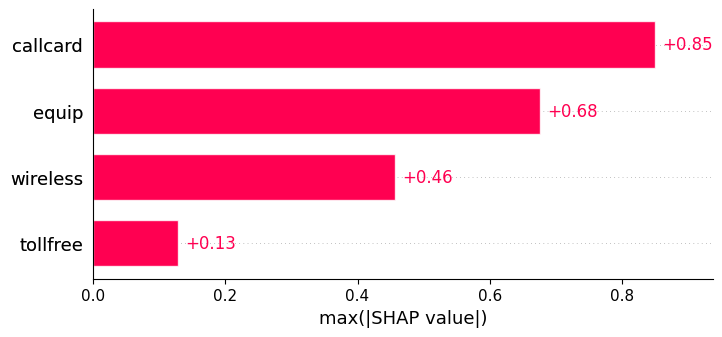

In [ ]:
shap.plots.bar(shap_values_churn_l.abs.max(0))

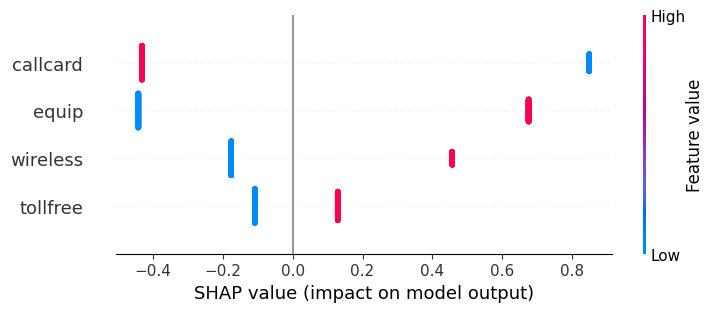

In [ ]:
shap.plots.beeswarm(shap_values_churn_l)

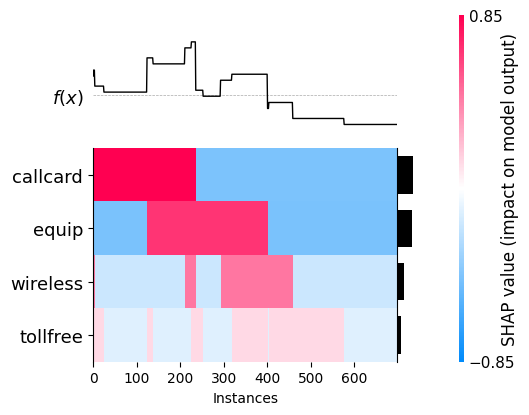

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values_churn_l[:1000])

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(xtrain),
feature_names=list(xtrain.columns),
class_names=['churn'],
verbose=True, mode='classification')


expl = explainer.explain_instance(xtest.iloc[0], l_model.predict_proba,
num_features=16)
expl.as_list()

Intercept 0.41257979489442476
Prediction_local [0.2892195]
Right: 0.27093118348898243


[('0.00 < callcard <= 1.00', -0.24487433541551032),
 ('0.00 < equip <= 1.00', 0.19428688903446886),
 ('wireless <= 0.00', -0.11244557055235066),
 ('0.00 < tollfree <= 1.00', 0.039672720096894654)]

In [ ]:
pd.DataFrame(expl.as_list())

,0,1
0,0.00 < callcard <= 1.00,-0.244874
1,0.00 < equip <= 1.00,0.194287
2,wireless <= 0.00,-0.112446
3,0.00 < tollfree <= 1.00,0.039673


In [ ]:
expl.show_in_notebook(show_table=True)